In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import numpy as np
from datetime import timedelta
from IPython.display import display

In [2]:
# Settings to use for all plots
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.style.use('ggplot')
cmap = cm.get_cmap('Blues')
secs = 3600
beams = ["1e14", "1e15", "1e16"]

#### Load Data

In [3]:
data_files = []

for root, dirs, files in sorted(os.walk("./icpp_training_results")):
    if "stopping" in root:
        for i in files:
            f = os.path.join(root, i)
            data_files.append(f)

## Epoch Savings

For epoch savings, the number of GPUs should be (?) irrelevant, so we just use the different GPUs as repeated tests. It doesn't seem to be irrelevant, though. We should look into that. Is it just random? Should do more tests to find out.

In [4]:
def plot_epochs_savings(beams, num_epochs_no_stop, stop_1e14, stop_1e15, stop_1e16):
    width = 0.2
    multiplier = 0

    epochs_run = {
        'Baseline': np.repeat(num_epochs_no_stop, 3),
        '1GPU with PENGUIN': (stop_1e14[0], stop_1e15[0], stop_1e16[0]),
        '4GPU with PENGUIN': (stop_1e14[1], stop_1e15[1], stop_1e16[1]),
    }

    x = np.arange(len(beams))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))
    colors = cm.Blues(np.linspace(0.4, 0.9, 3))

    for index, (label, num_epochs) in enumerate(epochs_run.items()):
        print(label, num_epochs)
        offset = width * multiplier
        rects = ax.barh(x + offset, num_epochs, width, label=label, color=colors[index]) 
        labels = [str(round((1-(num_epochs[i]/num_epochs_no_stop))*100, 1))+'%' for i in range(len(num_epochs))]
        ax.bar_label(rects, labels=labels ,padding=2)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Epochs Completed', fontsize=20)
    ax.set_ylabel('Beam Intensity', fontsize=20)

    ax.set_title('Percent Epochs Saved', fontsize=25)
    ax.set_yticks(x + width, beams)
    ax.legend(loc='upper right',fontsize=12)

    plt.savefig('figures/epochs_saved.png')
    display(fig)
    plt.clf()
    return

def calculate_and_plot_epochs_savings(files):
    no_stop_1e14, no_stop_1e15, no_stop_1e16 = [], [], []
    stop_1e14, stop_1e15, stop_1e16 = [], [], []
    stop_1e14_len, stop_1e15_len, stop_1e16_len = [], [], []
   
    for f in files: 
        if "no" in f:
            df = pd.read_csv(f)
            num_epochs_no_stopping = len(df.index) # non-stopped file

            if "1e14" in f:
                no_stop_1e14.append(df) 
            elif "1e15" in f:
                no_stop_1e15.append(df)
            elif "1e16" in f:
                no_stop_1e16.append(df)

        beam = f.split('/')[-1].split('_')[1].strip()
        gpus = f.split('/')[-1].split('_')[0].strip()
        stop = f.split('/')[-1].strip()
        if "stopping" in stop:
            df = pd.read_csv(f)
            print(f"Num epochs completed for {gpus} {beam} with PENGUIN:", len(df.index))

            if "1e14" in stop:
                stop_1e14.append(df) 
                stop_1e14_len.append(len(df.index))
            elif "1e15" in stop:
                stop_1e15.append(df) 
                stop_1e15_len.append(len(df.index))
            elif "1e16" in stop:
                stop_1e16.append(df) 
                stop_1e16_len.append(len(df.index))

    print()
    avg_epochs_completed = [sum(stop_1e14_len)/len(stop_1e14_len), sum(stop_1e15_len)/len(stop_1e15_len), sum(stop_1e16_len)/len(stop_1e16_len)]
    for i, b in enumerate(beams):
        print(f"Avg. epochs completed for {b}: {avg_epochs_completed[i]}")
        percent_epochs_saved = 1-(avg_epochs_completed[i]/num_epochs_no_stopping)
        print(f"Avg. percent epochs saved for {b}: {percent_epochs_saved*100}\n")

    plot_epochs_savings(beams, num_epochs_no_stopping, stop_1e14_len, stop_1e15_len, stop_1e16_len)

    return [no_stop_1e14, no_stop_1e15, no_stop_1e16], [stop_1e14, stop_1e15, stop_1e16]

Num epochs completed for 1gpu 1e14 with PENGUIN: 2167
Num epochs completed for 1gpu 1e15 with PENGUIN: 1647
Num epochs completed for 1gpu 1e16 with PENGUIN: 1737
Num epochs completed for 4gpu 1e16 with PENGUIN: 1639
Num epochs completed for 4gpu 1e15 with PENGUIN: 1499
Num epochs completed for 4gpu 1e14 with PENGUIN: 2101

Avg. epochs completed for 1e14: 2134.0
Avg. percent epochs saved for 1e14: 14.639999999999997

Avg. epochs completed for 1e15: 1573.0
Avg. percent epochs saved for 1e15: 37.08

Avg. epochs completed for 1e16: 1688.0
Avg. percent epochs saved for 1e16: 32.48

Baseline [2500 2500 2500]
1GPU with PENGUIN (2167, 1647, 1737)
4GPU with PENGUIN (2101, 1499, 1639)


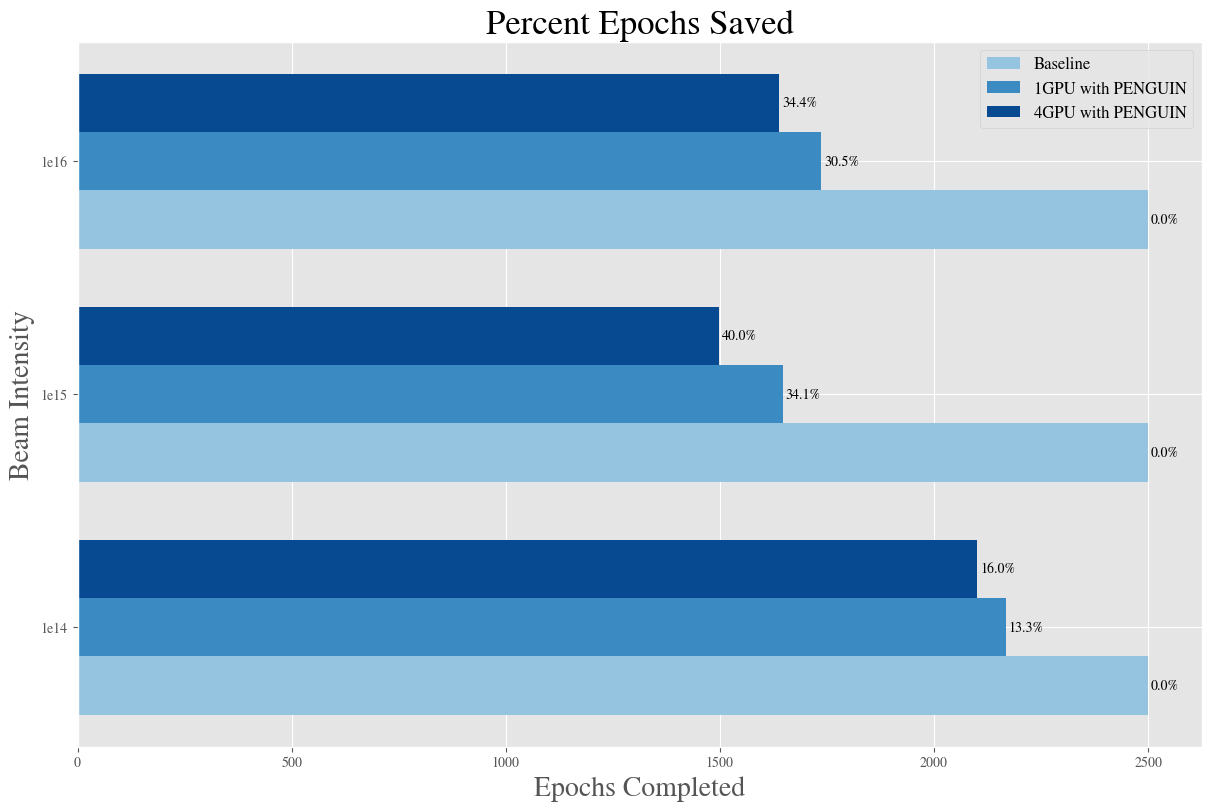

<Figure size 1200x800 with 0 Axes>

In [5]:
no_stop, stop = calculate_and_plot_epochs_savings(data_files)

## Time Savings

In [6]:
def print_wall_times(no_stop, stop):
    print("No PENGUIN:")
    for n, beam in enumerate(no_stop): # Non-stop DataFrames for 1e14, 1e15, 1e16
        for i, df in enumerate(beam):
            if i % 2 == 0: # 1 GPU
                try:
                    gpu1_time = df['epoch_times'].sum()/secs
                    print(f"1 GPU: {gpu1_time}")
                except:
                    print("Non stop 1 GPU: these runs don't have epoch times")
            else: # 4 GPU
                try:
                    gpu4_time = df['epoch_times'].sum()/secs
                    print(f"4 GPUS: {gpu4_time}")
                except:
                    print("Non stop 4 GPU: these runs don't have epoch times")
    print("\nWith PENGUIN:")
    for n, val in enumerate(stop): # Stopped DataFrames for 1e14, 1e15, 1e16
        for i, df in enumerate(val):
            if i % 2 == 0: # 1 GPU
                try:
                    gpu1_time = df['epoch_times'].sum()/secs
                    print(f"1 GPU: {gpu1_time}")
                except:
                    print("Stop 1 GPU: these runs don't have epoch times")
            else: # 4 GPU
                try:
                    gpu4_time = df['epoch_times'].sum()/secs
                    print(f"4 GPUS: {gpu4_time}")
                except:
                    print("Stop 4 GPU: these runs don't have epoch times")
    return

def get_run_time(row):
    days = int(row.split('-')[0])
    hours = int(row.split('-')[1].split('_')[0])
    minutes = int(row.split('-')[1].split('_')[1])
    seconds = int(row.split('-')[1].split('_')[2])
    time = timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    return time

def get_run_seconds(row):
    days = int(row.split('-')[0])
    hours = int(row.split('-')[1].split('_')[0])
    minutes = int(row.split('-')[1].split('_')[1])
    seconds = int(row.split('-')[1].split('_')[2])
    time = timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    return time.total_seconds()

def plot_times():
    time_df = pd.read_csv('./icpp_training_results/time_to_run.csv')

    # DataFrame filtering conditions
    b14, b15, b16 = (time_df['dataset']==14), (time_df['dataset']==15), (time_df['dataset']==16)
    no_stop, stop = (time_df['stopping']==False), (time_df['stopping']==True)
    gpu1, gpu4 = (time_df['gpu']==1), (time_df['gpu']==4)
    time_format = 'total_seconds'

    # Filtering data
    no_stop_1e14 = np.array([time_df[b14 & no_stop & gpu1][time_format].item(), time_df[b14 & no_stop & gpu4][time_format].item()])/secs
    no_stop_1e15 = np.array([time_df[b15 & no_stop & gpu1][time_format].item(), time_df[b15 & no_stop & gpu4][time_format].item()])/secs
    no_stop_1e16 = np.array([time_df[b16 & no_stop & gpu1][time_format].item(), time_df[b16 & no_stop & gpu4][time_format].item()])/secs

    stop_1e14 = np.array([time_df[b14 & stop & gpu1][time_format].item(), time_df[b14 & stop & gpu4][time_format].item()])/secs
    stop_1e15 = np.array([time_df[b15 & stop & gpu1][time_format].item(), time_df[b15 & stop & gpu4][time_format].item()])/secs
    stop_1e16 = np.array([time_df[b16 & stop & gpu1][time_format].item(), time_df[b16 & stop & gpu4][time_format].item()])/secs

    epochs_run = {
        '1GPU without PENGUIN': (no_stop_1e14[0], no_stop_1e15[0], no_stop_1e16[0]),
        '1GPU with PENGUIN': (stop_1e14[0], stop_1e15[0], stop_1e16[0]),
        '4GPU without PENGUIN': (no_stop_1e14[1], no_stop_1e15[1], no_stop_1e16[1]),
        '4GPU with PENGUIN': (stop_1e14[1], stop_1e15[1], stop_1e16[1]),
    }

    x = np.arange(len(beams))  # the label locations
    width = 0.17  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))
    colors = cm.Blues(np.linspace(0.4, 0.9, 4))

    print()
    for index, (label, times) in enumerate(epochs_run.items()):
        print(label, times)
        offset = width * multiplier
        rects = ax.bar(x + offset, times, width, label=label, color=colors[index]) #, color= cmap(np.linspace(0, 1, 3))
        labels = [round(time, 2) for time in times]
        ax.bar_label(rects, labels=labels ,padding=2)
        multiplier += 1

    # Labels, title, x-axis tick labels, etc.
    ax.set_ylabel('Run Time (hours)', fontsize=20)
    ax.set_xlabel('Beam Intensity', fontsize=20)

    ax.set_title('Wall Hours Spent', fontsize=25)
    ax.set_xticks(x + width, beams)
    ax.legend(loc='upper right', fontsize=12)

    plt.savefig('figures/time_saved.png')
    display(fig)

    return

def save_and_plot_times():
    gpu=[1,1,1,1,1,1,4,4,4,4,4,4]
    stopping=[False, False, False, True, True, True, False, False, False, True, True, True]
    dataset=['14','15','16','14','15','16','14','15','16','14','15','16']
    time=['2-02_01_42','2-03_52_23','2-00_38_20','1-22_33_04','1-12_05_38','1-08_18_16','0-14_32_18','0-14_54_32','0-13_53_12','0-12_03_46','0-09_10_05','0-09_27_38']

    time_df = pd.DataFrame()
    time_df['gpu'] = gpu
    time_df['dataset'] = dataset
    time_df['stopping'] = stopping
    time_df['time'] = time
    time_df['total_time'] = time_df['time'].apply(get_run_time)
    time_df['total_seconds'] = time_df['time'].apply(get_run_seconds)

    time_df.to_csv('./icpp_training_results/time_to_run.csv', index=False)
    plot_times()
    return 

### Observe the Total GPU Wall Times

In [7]:
print_wall_times(no_stop, stop)

No PENGUIN:
Non stop 1 GPU: these runs don't have epoch times
Non stop 4 GPU: these runs don't have epoch times
Non stop 1 GPU: these runs don't have epoch times
Non stop 4 GPU: these runs don't have epoch times
Non stop 1 GPU: these runs don't have epoch times
Non stop 4 GPU: these runs don't have epoch times

With PENGUIN:
1 GPU: 46.350929785768194
4 GPUS: 40.50905620786879
1 GPU: 35.91131767789523
Stop 4 GPU: these runs don't have epoch times
1 GPU: 32.134367143445544
4 GPUS: 31.63662725733386


### Now plot all wall hours of each run


1GPU without PENGUIN (50.028333333333336, 51.87305555555555, 48.638888888888886)
1GPU with PENGUIN (46.55111111111111, 36.09388888888889, 32.30444444444444)
4GPU without PENGUIN (14.538333333333334, 14.908888888888889, 13.886666666666667)
4GPU with PENGUIN (12.062777777777777, 9.168055555555556, 9.460555555555555)


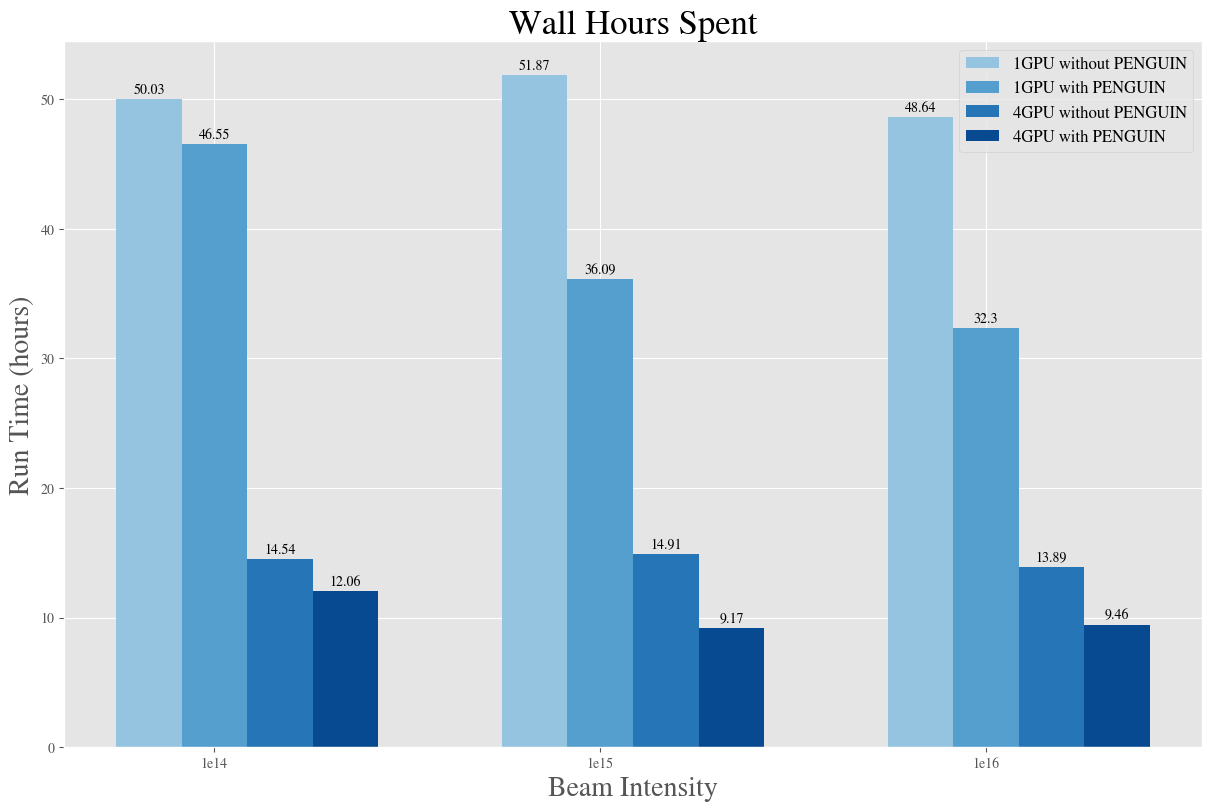

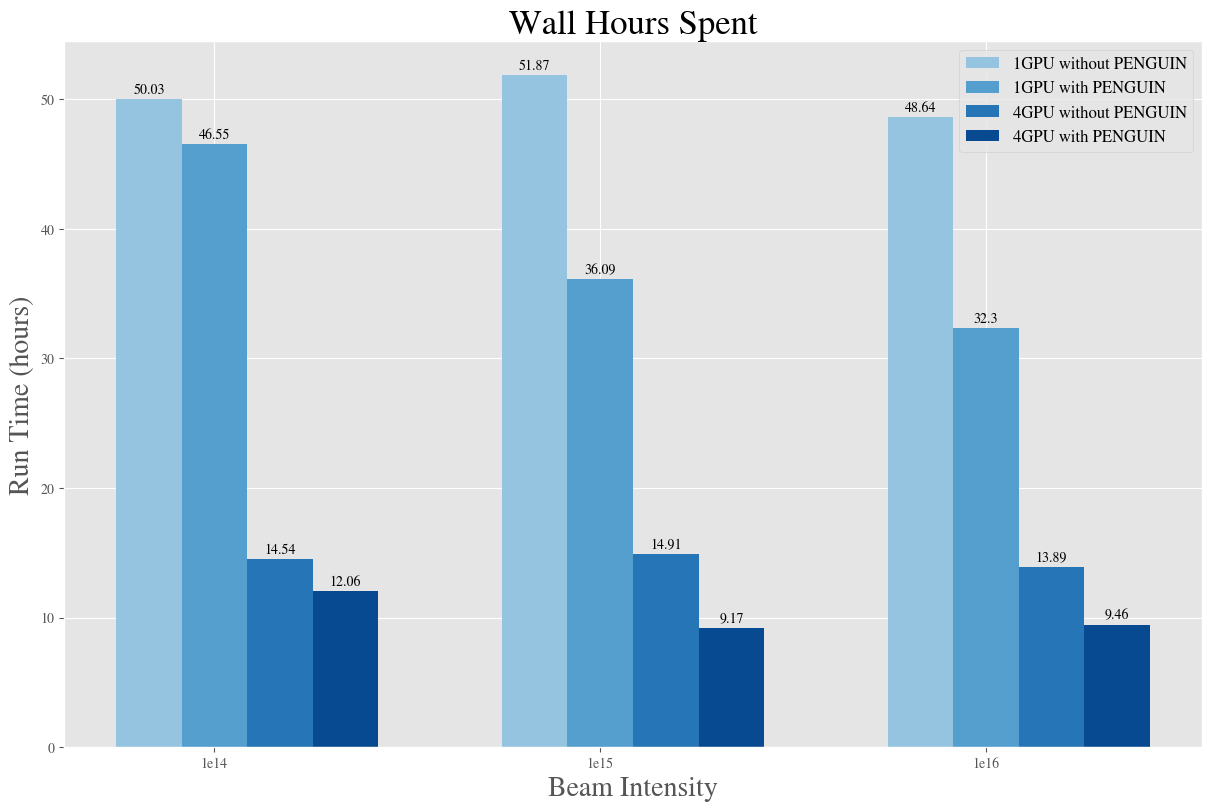

In [8]:
save_and_plot_times()

## Classification Results and Pareto Optimality

In [9]:
def one_line_per_arch_penguin(arch_df):
    sorted_by_epoch = arch_df.sort_values('epoch', ascending=False)
    if sorted_by_epoch['converged'].iloc[0] == True:
        to_return = sorted_by_epoch['predictions'].iloc[0]
        # print(to_return)
    else:
        to_return = sorted_by_epoch['val_accs'].iloc[0]
    return pd.Series({'final_acc':to_return, 'flops':arch_df['flops'].iloc[0], 'converged':sorted_by_epoch['converged'].iloc[0]})

def one_line_per_arch(arch_df):
    sorted_by_epoch = arch_df.sort_values('epoch', ascending=False)
    to_return = sorted_by_epoch['val_accs'].iloc[0]
    return pd.Series({'final_acc':to_return, 'flops':arch_df['flops'].iloc[0], 'converged':sorted_by_epoch['converged'].iloc[0]})

def is_pareto_efficient_simple(unadjusted_costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """

    # this assumes minimization, so we need to invert accuracy to make bigger, better
    # we should look more closely at this
    costs = np.zeros(unadjusted_costs.shape, dtype=float)
    costs[:,1] = unadjusted_costs[:,1]
    costs[:,0] = unadjusted_costs[:,0] * -1
    
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def make_graphic(one_line, pareto_optimals, title="FLOPS vs. Val Accuracy per Architecture", gens=10, children=10):
    fig, ax = plt.subplots(layout='constrained', figsize=(10, 8), dpi=160)

    as_numpy = one_line.to_numpy()

    plt.xlabel('FLOPS', fontsize=20)
    plt.ylabel('Validation Accuracy', fontsize=20)
    plt.title(title, fontsize=24)
    plt.ylim(85, 100.2)

    colors = cm.Blues(np.linspace(0, 1, gens))
    size=100

    labels = list()
    start, end, ng = 0, 0, 0
    for g in range(0, gens * children):
        if g == 0 or g % gens == 0:
            start = g
            end = start + (children - 1)
            labels.append(f"Generation {g // gens}")
        
            ngen = as_numpy[start:end + 1]
            ax.scatter(as_numpy[start:end+1, 2], as_numpy[start:end+1, 1], color=colors[g // gens], s=size, label=f"Generation {g // gens}", zorder=3)
    
    accs = pareto_optimals['final_acc'].to_numpy()
    flops = pareto_optimals['flops'].to_numpy()
    labels.append('Pareto Optimal')
    ax.scatter(flops, accs, s=250, marker='o', color='tab:orange', facecolor='None', linewidths=1.2, label='Pareto Optimal', zorder=10)
    plt.legend(labels, loc='lower right', fontsize=15)

    plt.savefig('figures/'+title.replace(" ", "_")+'.png')
    display(fig)
    plt.clf()
    return 


def plot_paretos(no_stop, stop):

    for n, beam in enumerate(no_stop): # Non-stop DataFrames for 1e14, 1e15, 1e16
        if n == 0: # 1e14
            tb = "Low Beam"
        elif n == 1: # 1e15
            tb = "Medium Beam"
        elif n == 2: # 1e16
            tb = "High Beam"
            
        for i, df in enumerate(beam):
            if i % 2 == 0: # 1 GPU
                title = f'1GPU with {tb} without PENGUIN'
            else:
                title = f'4GPU with {tb} without PENGUIN'

            by_arch = df.groupby('arch')
            one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
            sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
            costs = one_line[['final_acc', 'flops']].to_numpy()
            pareto_optimals = is_pareto_efficient_simple(costs)
            one_line['pareto_optimal'] = pareto_optimals
            pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
            print(f"\nParetos For {tb}:\n {pareto_optimal_arches}")
            make_graphic(one_line, pareto_optimal_arches, title=title)

    for n, beam in enumerate(stop): # Non-stop DataFrames for 1e14, 1e15, 1e16
        if n == 0: # 1e14
            tb = "Low Beam"
        elif n == 1: # 1e15
            tb = "Medium Beam"
        elif n == 2: # 1e16
            tb = "High Beam"
            
        for i, df in enumerate(beam):
            if i % 2 == 0: # 1 GPU
                title = f'1GPU with {tb} with PENGUIN'
            else:
                title = f'4GPU with {tb} with PENGUIN'

            by_arch = df.groupby('arch')
            one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
            sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
            costs = one_line[['final_acc', 'flops']].to_numpy()
            pareto_optimals = is_pareto_efficient_simple(costs)
            one_line['pareto_optimal'] = pareto_optimals
            pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
            print(f"\nParetos For {tb}:\n {pareto_optimal_arches}")
            make_graphic(one_line, pareto_optimal_arches, title=title)   
    
    return


Paretos For Low Beam:
     arch  final_acc     flops  converged  pareto_optimal
43    43  98.469388  777.6831       True            True
45    45  98.683547  895.2344       True            True
57    57  98.532376  813.1094       True            True
63    63  98.500882  795.3962       True            True
66    66  92.466616  450.7927      False            True
75    75  93.909045  595.4673       True            True
78    78  93.694885  513.3423      False            True
80    80  98.576468  877.5212       True            True
85    85  92.013102  433.0796       True            True
97    97  98.293021  677.2712      False            True
98    98  97.763920  597.5721       True            True


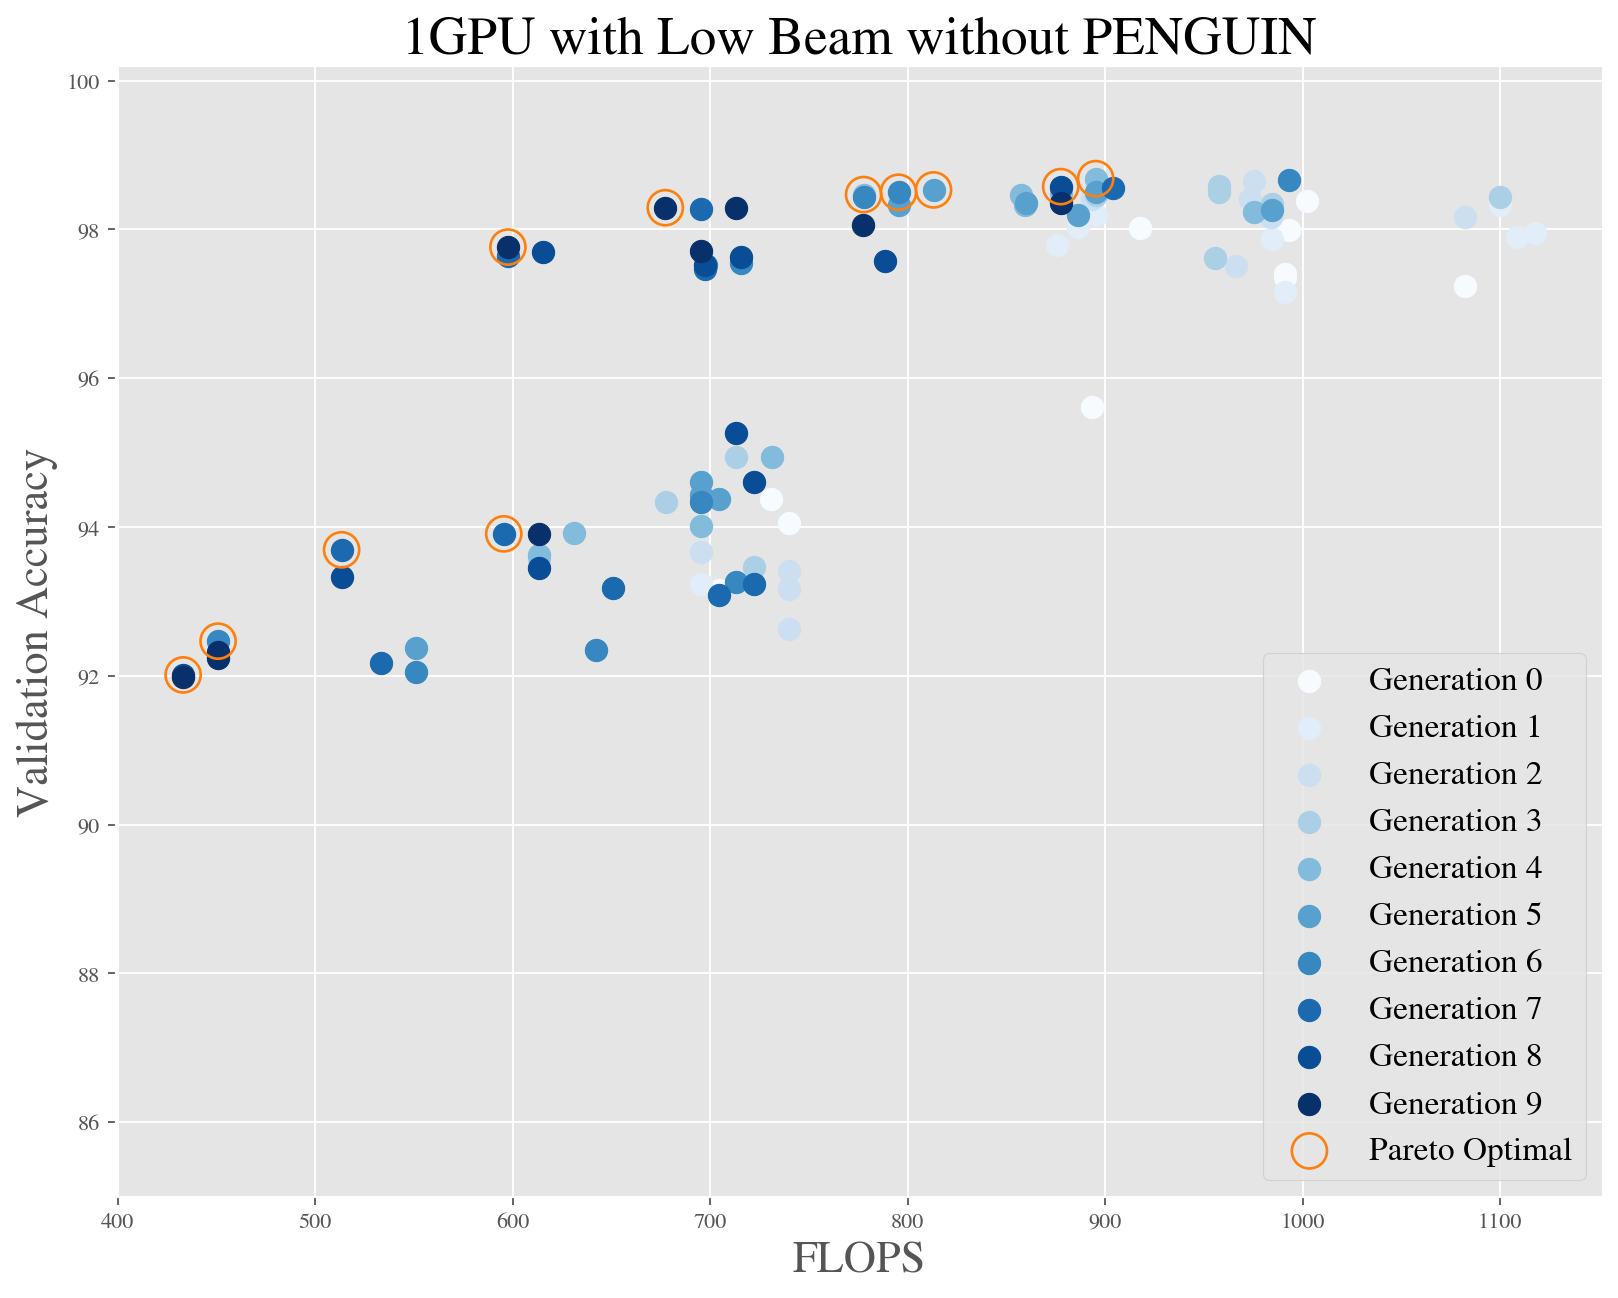


Paretos For Low Beam:
     arch  final_acc      flops  converged  pareto_optimal
10    10  98.759133  1108.8993      False            True
23    23  98.626858  1073.4730      False            True
56    56  93.424036   513.0555       True            True
59    59  97.751323   615.2853       True            True
60    60  98.582766   990.7743       True            True
66    66  98.431595   810.9603       True            True
72    72  98.425296   712.9844       True            True
83    83  93.902746   531.0555       True            True
95    95  92.573696   415.0796      False            True
97    97  98.463089   911.0853      False            True


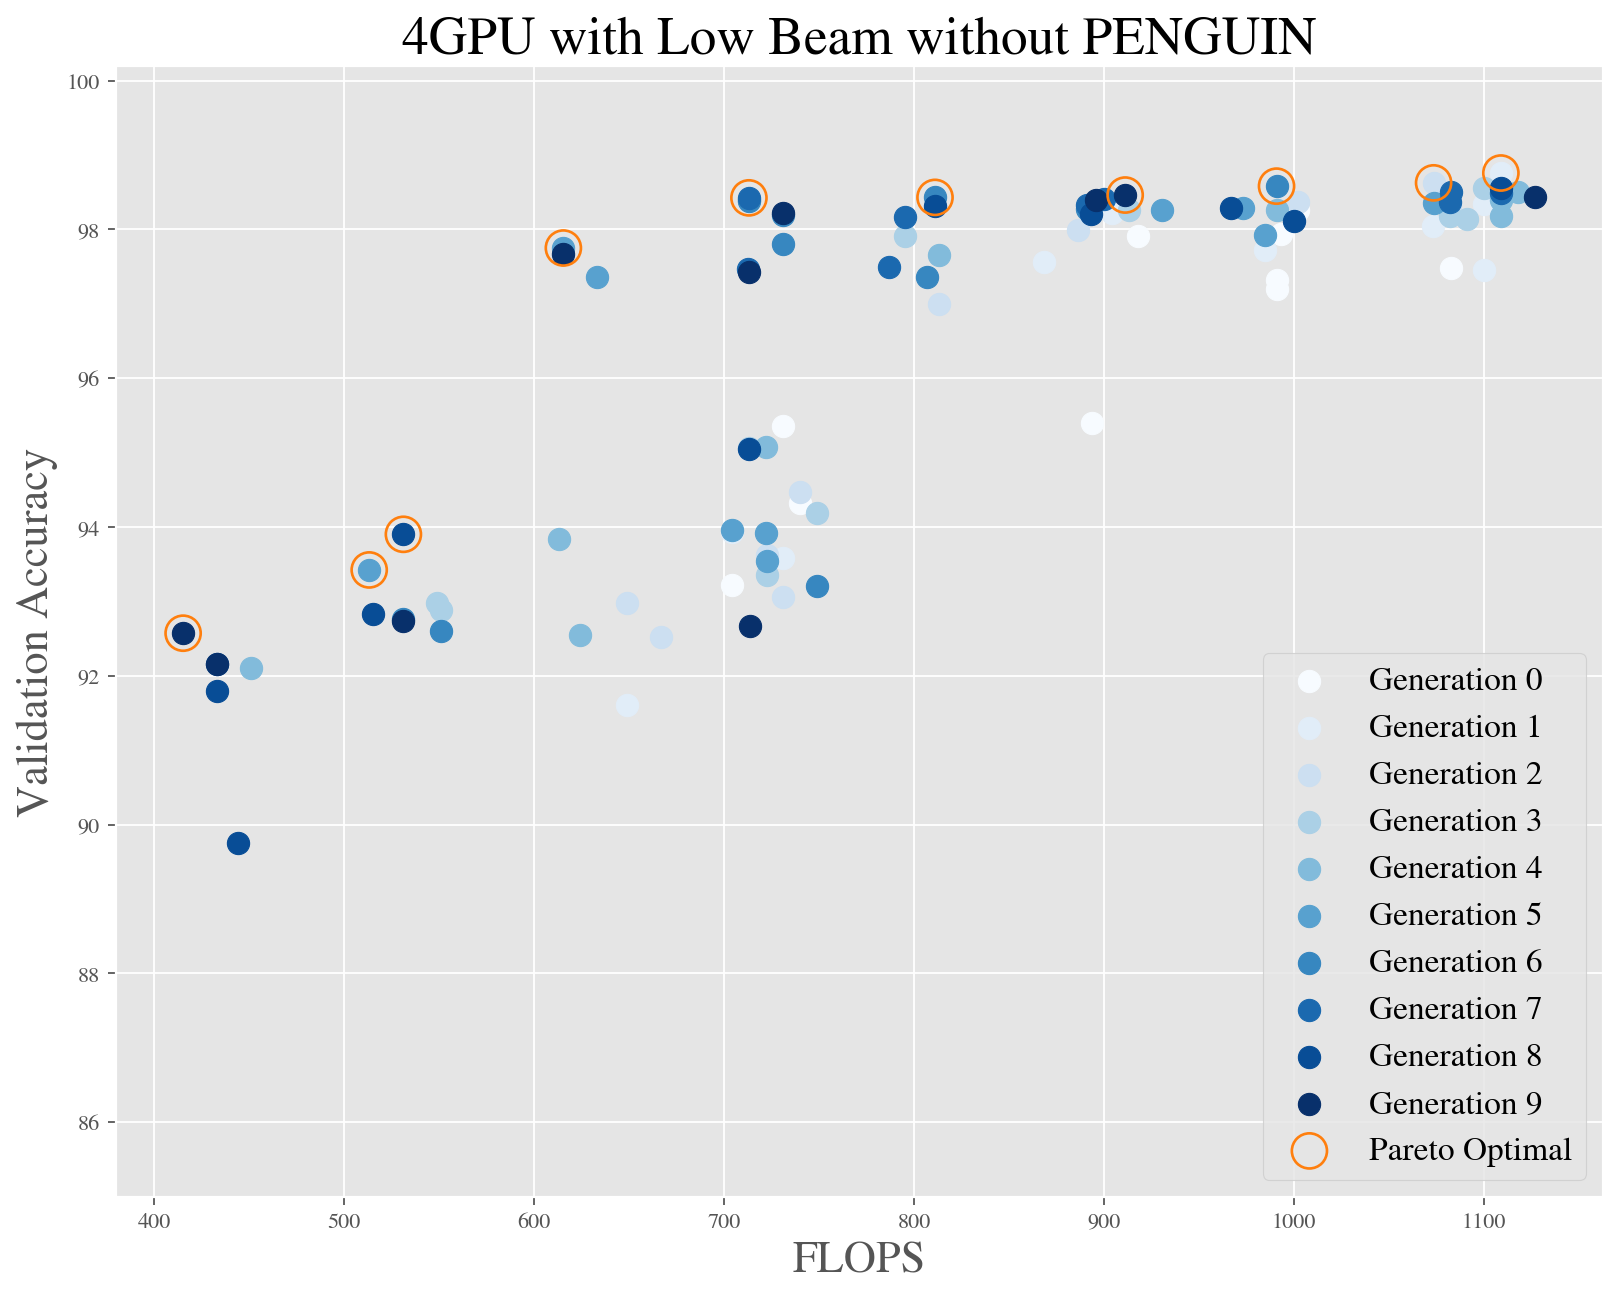


Paretos For Medium Beam:
     arch  final_acc     flops  converged  pareto_optimal
18    18  99.962207  886.7980      False            True
33    33  99.981104  903.9475      False            True
43    43  98.752834  613.4673       True            True
48    48  99.162257  615.0427       True            True
71    71  99.949609  793.2471      False            True
77    77  99.955908  886.2344       True            True
78    78  99.993701  921.9475      False            True
93    93  97.864701  533.2046       True            True
96    96  98.412698  597.3296       True            True
99    99  99.937012  695.2712       True            True


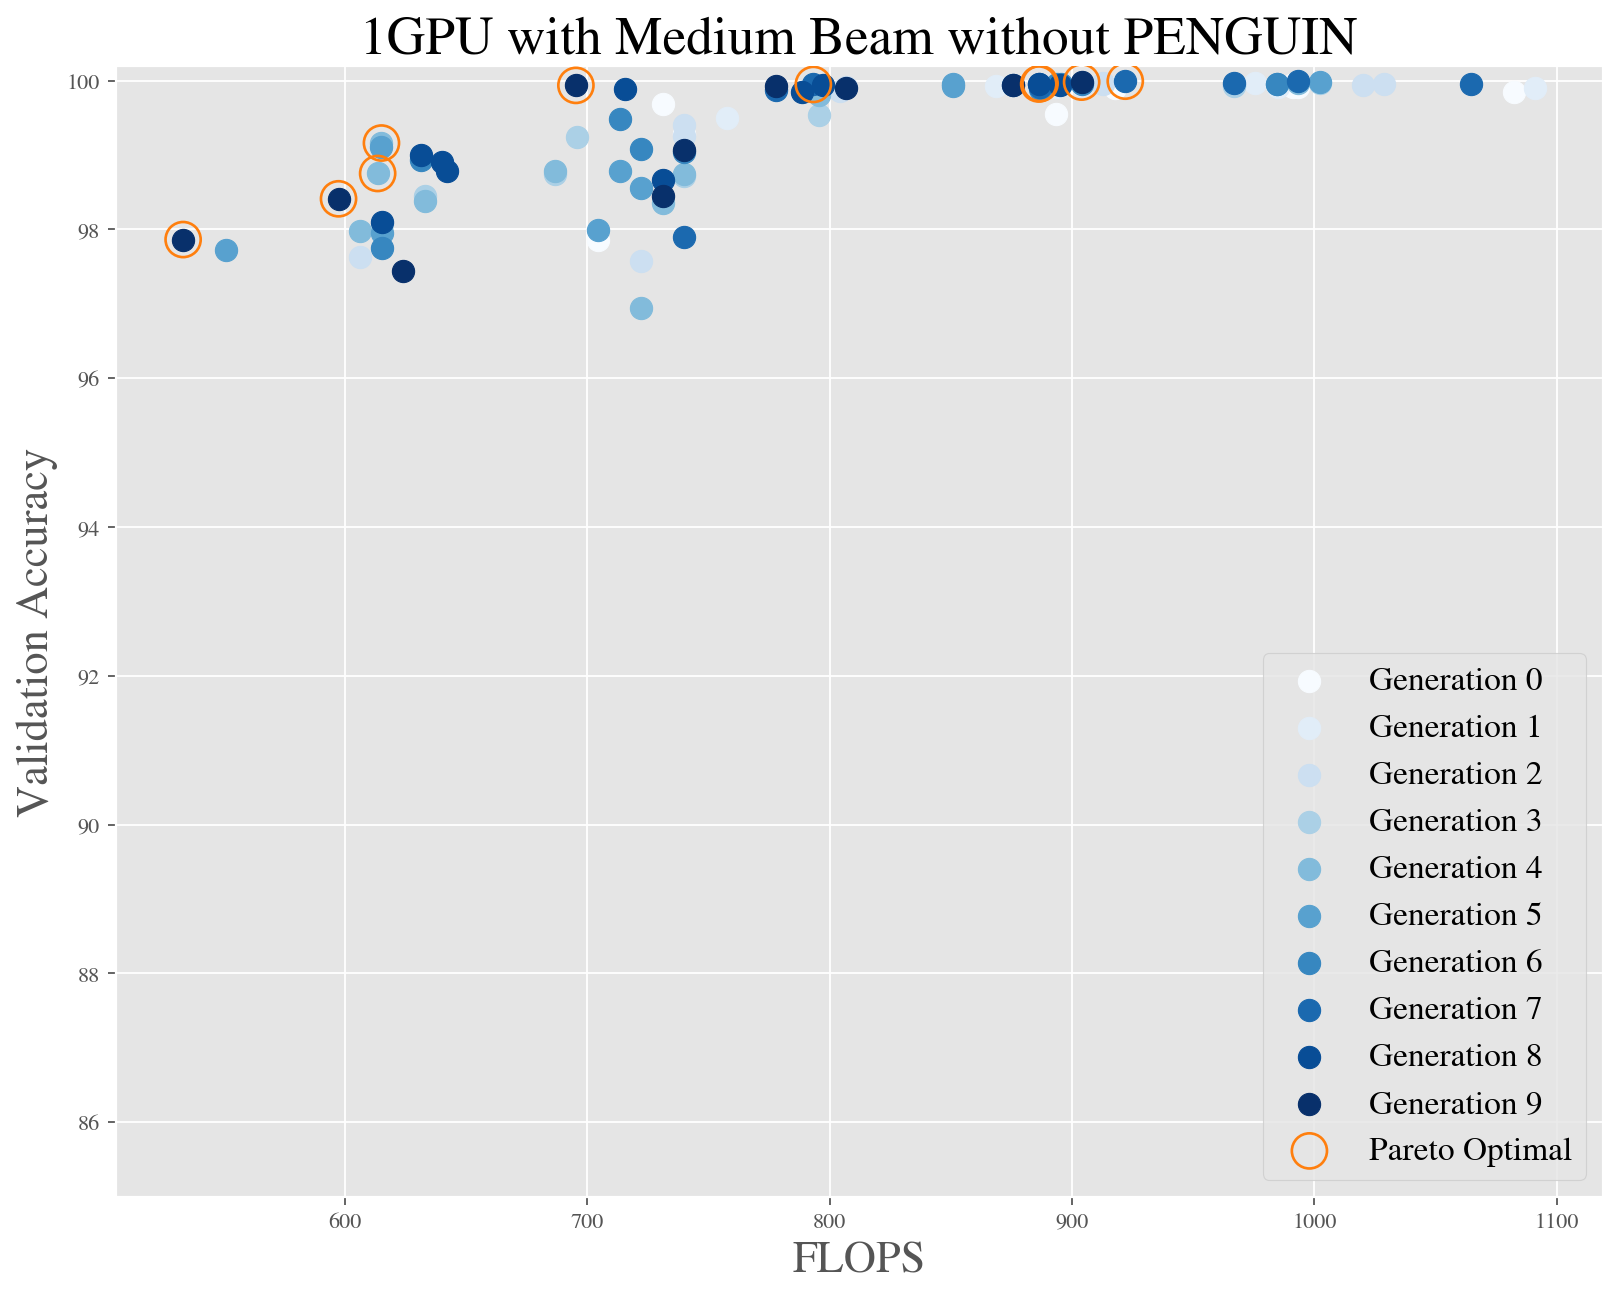


Paretos For Medium Beam:
     arch  final_acc      flops  converged  pareto_optimal
17    17  99.993701  1100.1861       True            True
37    37  99.962207   795.1094      False            True
38    38  99.955908   777.3962      False            True
62    62  99.212648   548.7686       True            True
64    64  99.987402   877.2344       True            True
81    81  99.332326   613.1805      False            True
86    86  99.577979   695.3055       True            True
90    90  99.930713   777.1094      False            True


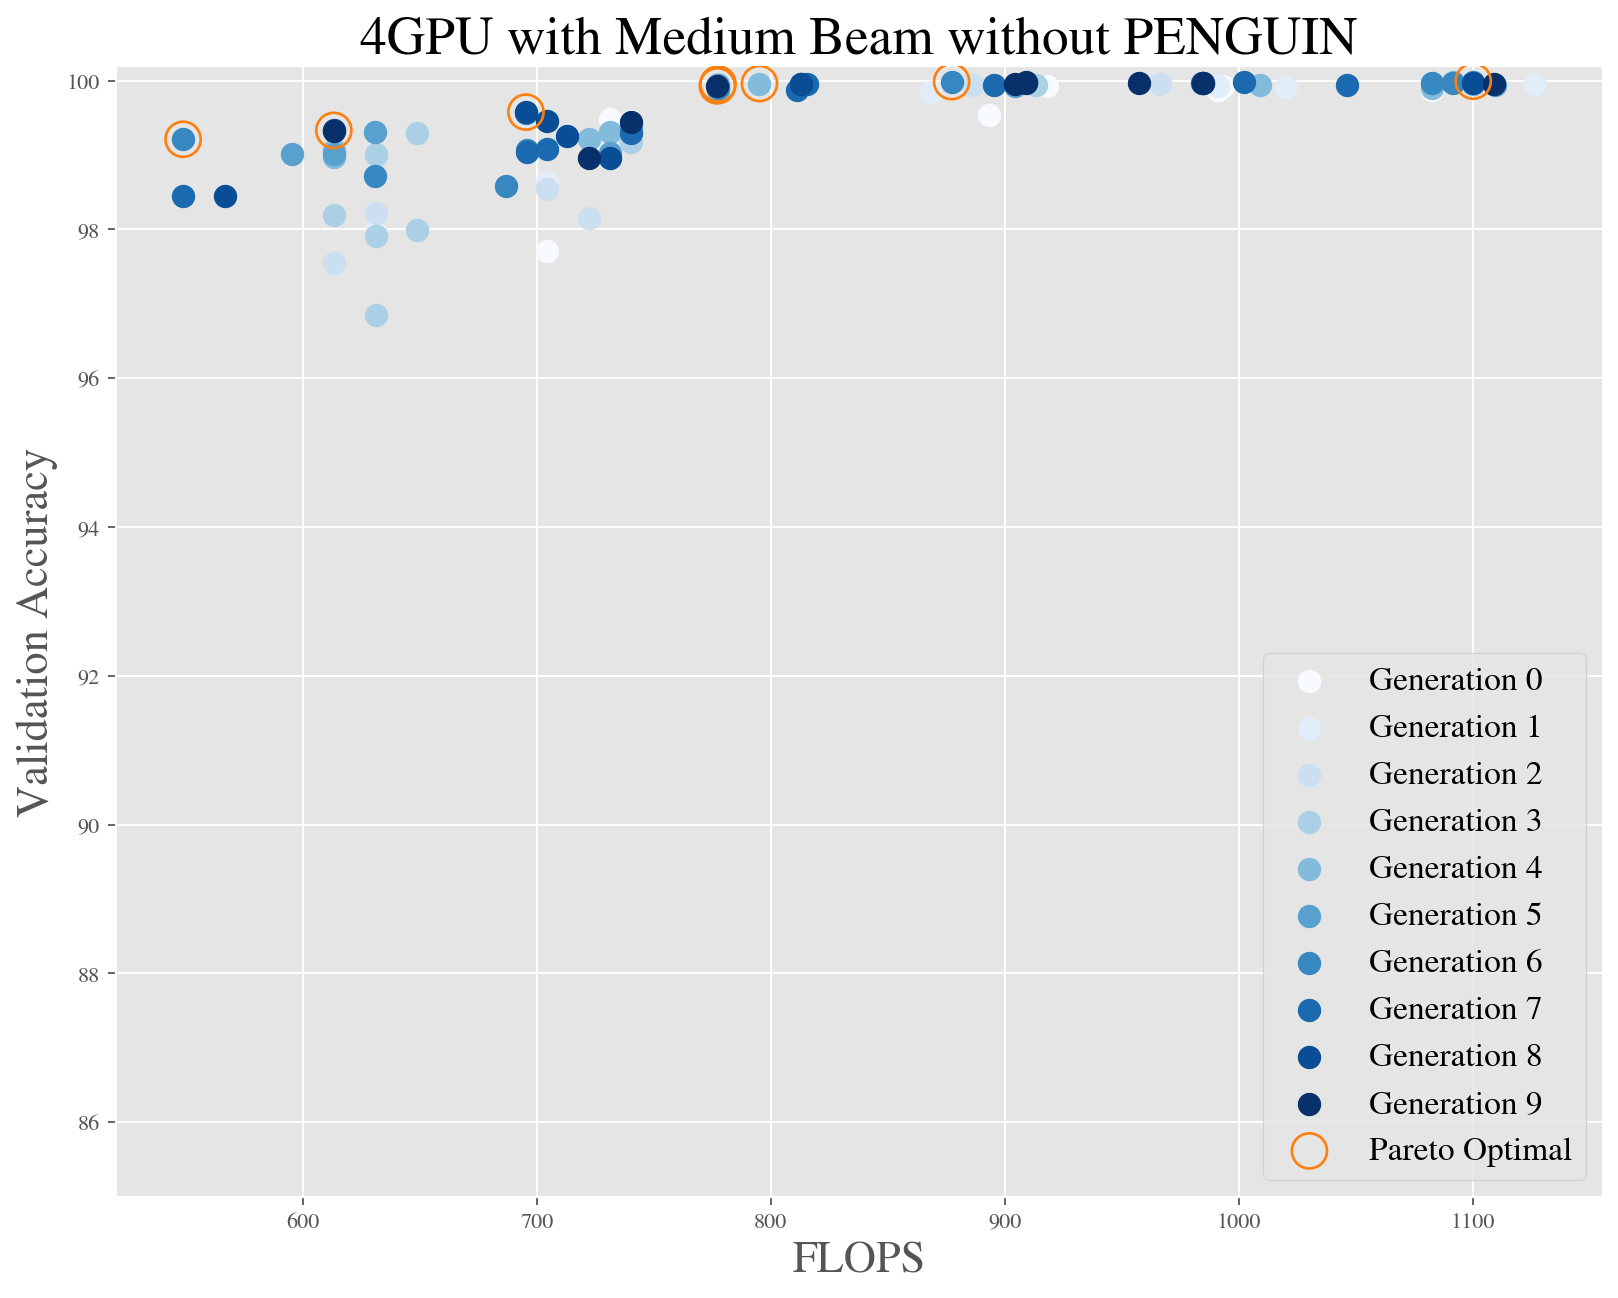


Paretos For High Beam:
     arch   final_acc     flops  converged  pareto_optimal
75    75   99.666163  334.8169       True            True
76    76  100.000000  513.3423      False            True
84    84   99.993701  495.3423       True            True
86    86   99.974805  450.7927       True            True
88    88   99.798438  352.8169       True            True
90    90   99.968506  432.7927       True            True
91    91   99.949609  415.0796      False            True
96    96   97.927690  251.2500       True            True


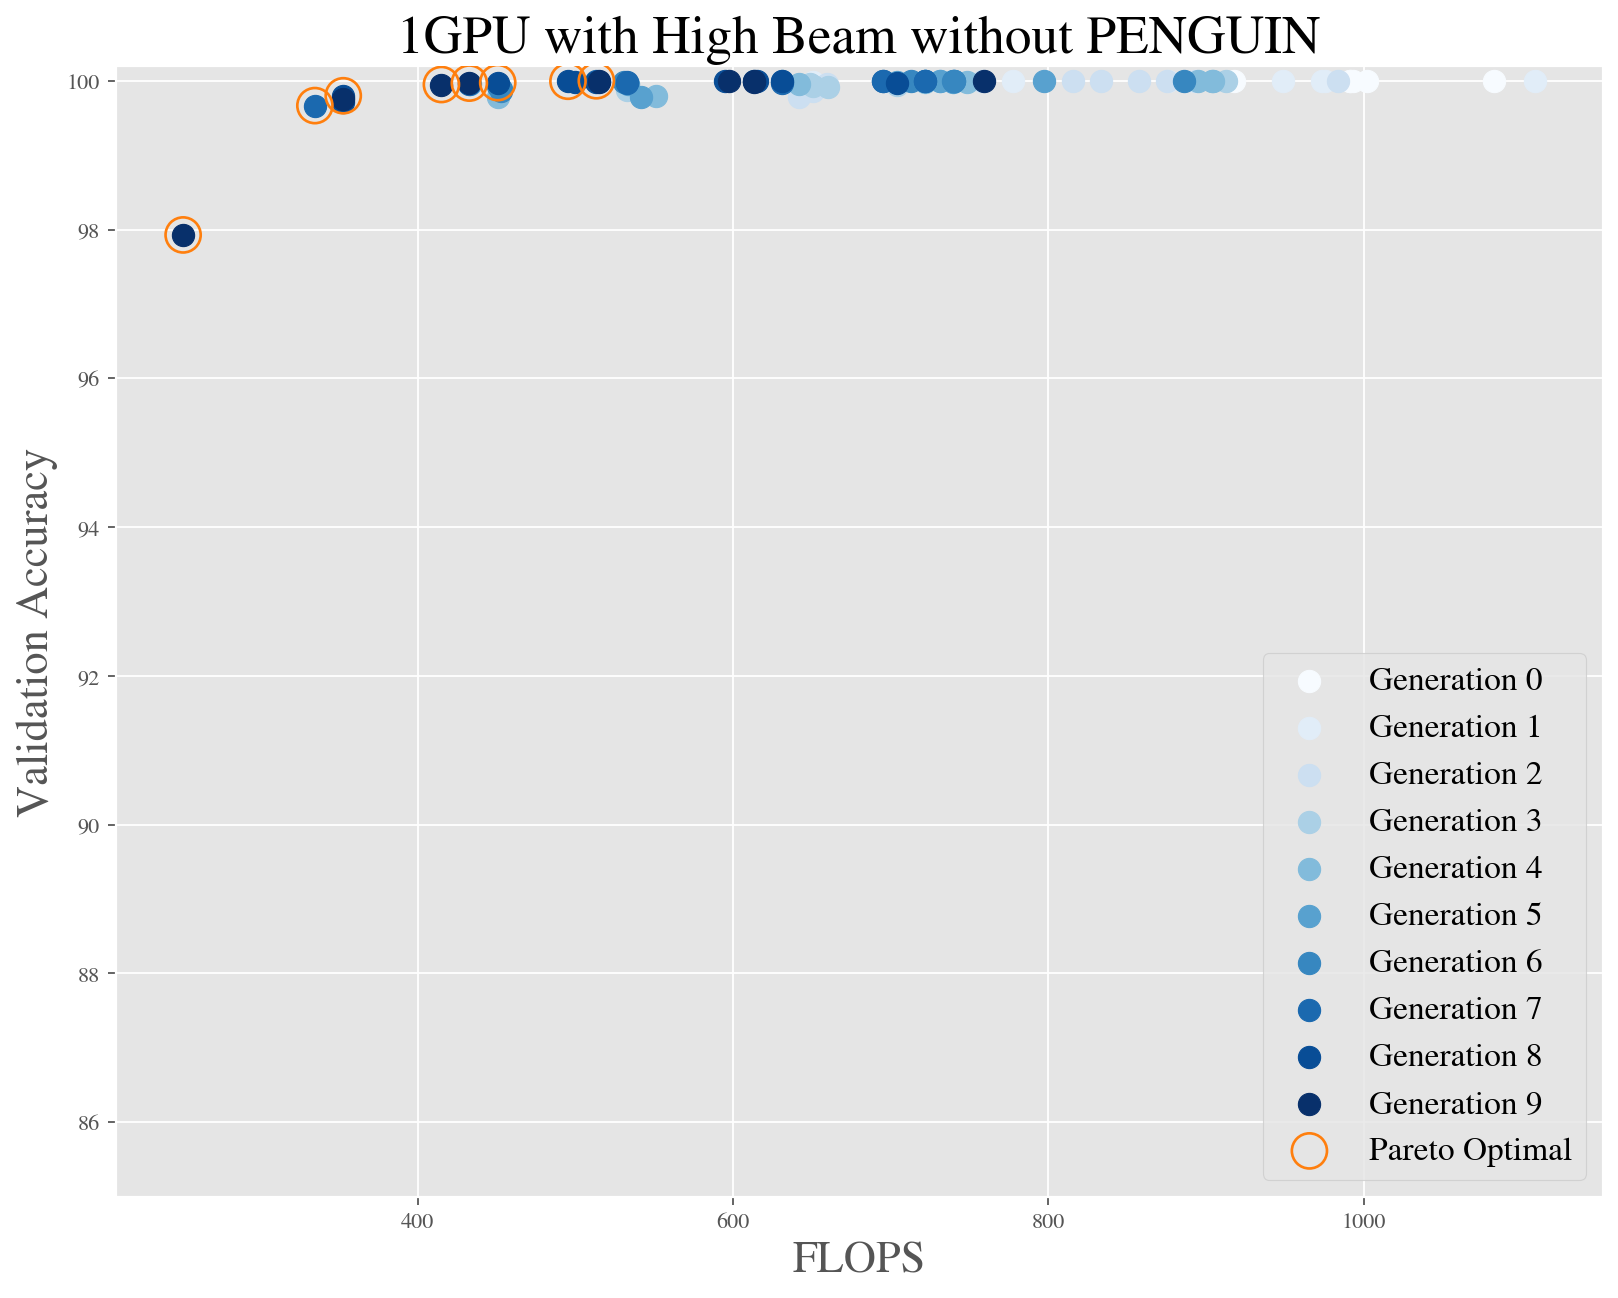


Paretos For High Beam:
     arch   final_acc     flops  converged  pareto_optimal
88    88  100.000000  495.3423       True            True
90    90   99.962207  432.7927      False            True


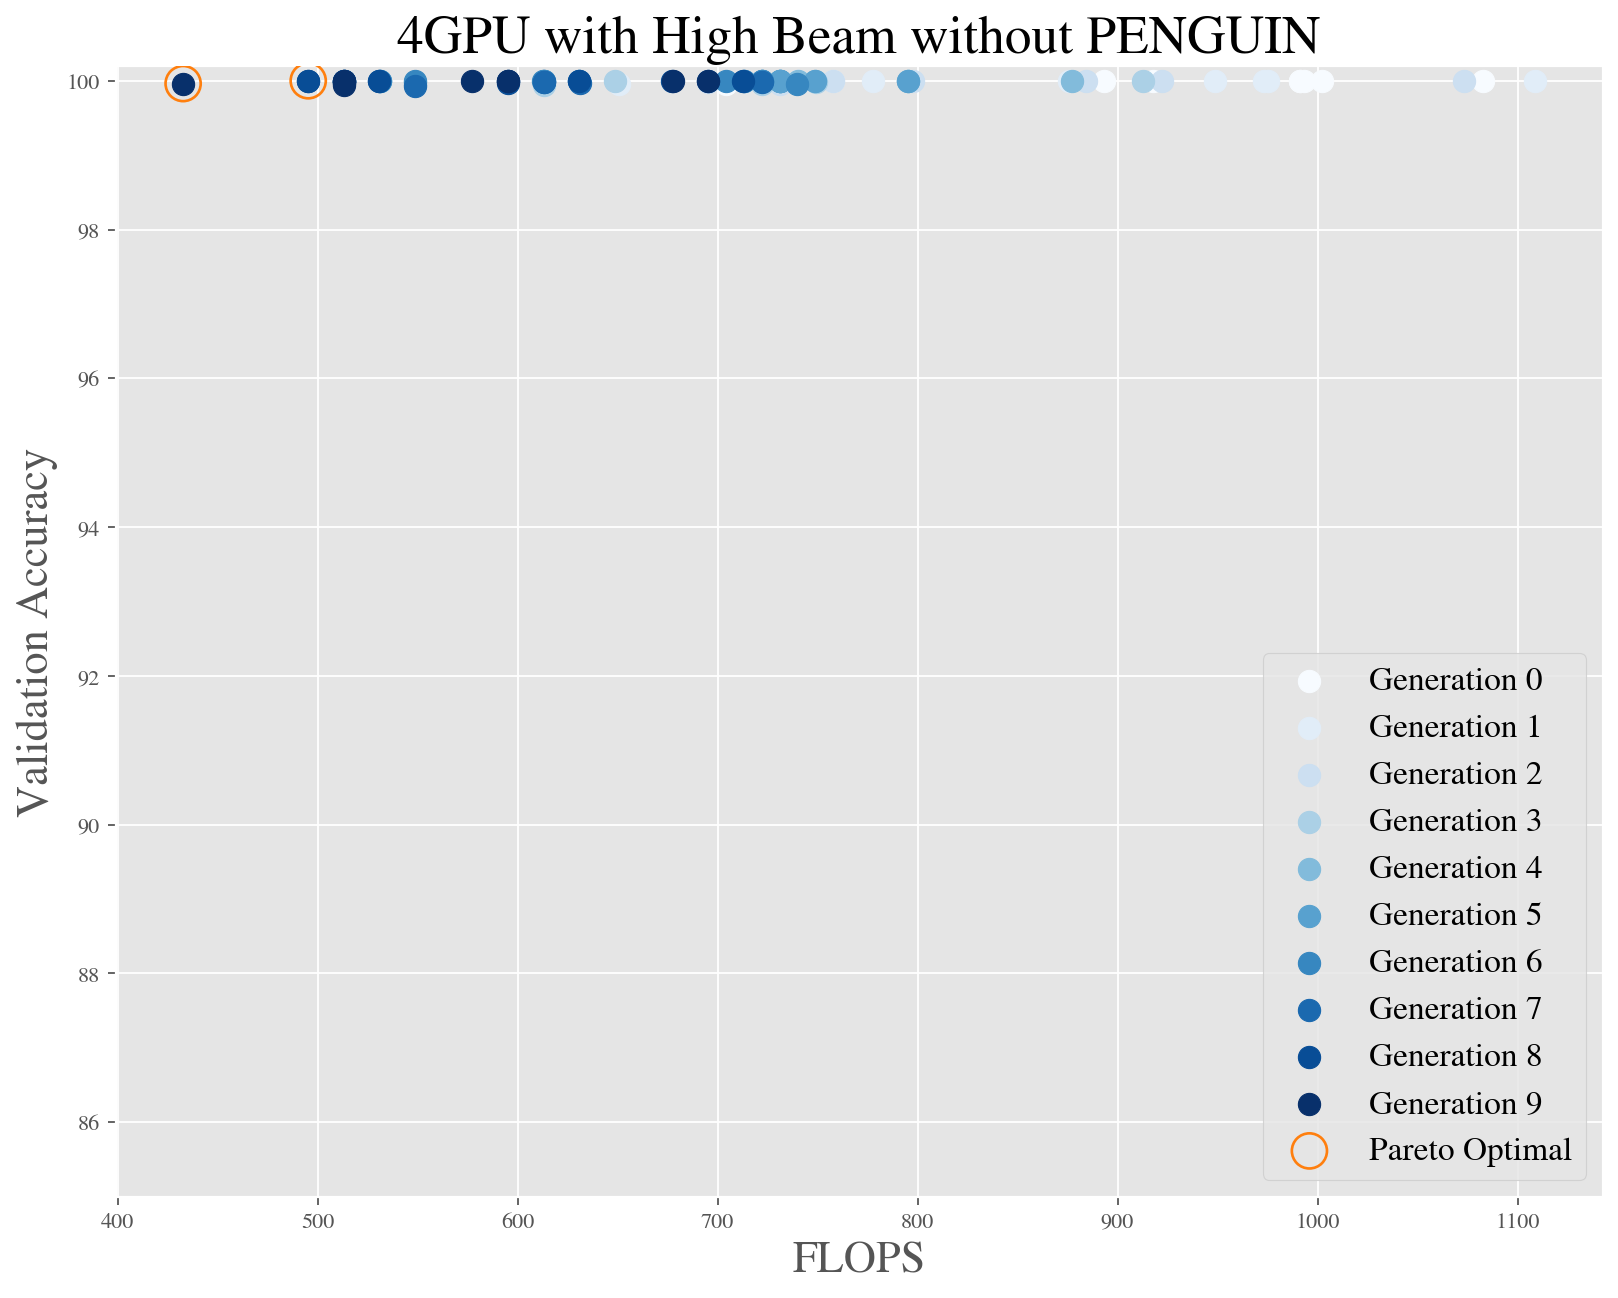


Paretos For Low Beam:
     arch  final_acc     flops  converged  pareto_optimal
23    23  98.217435  806.5353       True            True
29    29  98.551272  875.3721      False            True
31    31  94.110607  631.1805      False            True
55    55  97.820610  761.8221       True            True
60    60  98.122953  795.3962       True            True
61    61  97.826909  770.8221      False            True
71    71  97.971781  779.5353       True            True
83    83  98.582766  877.7980      False            True
85    85  93.562610  597.0427       True            True
99    99  97.738725  661.6971       True            True


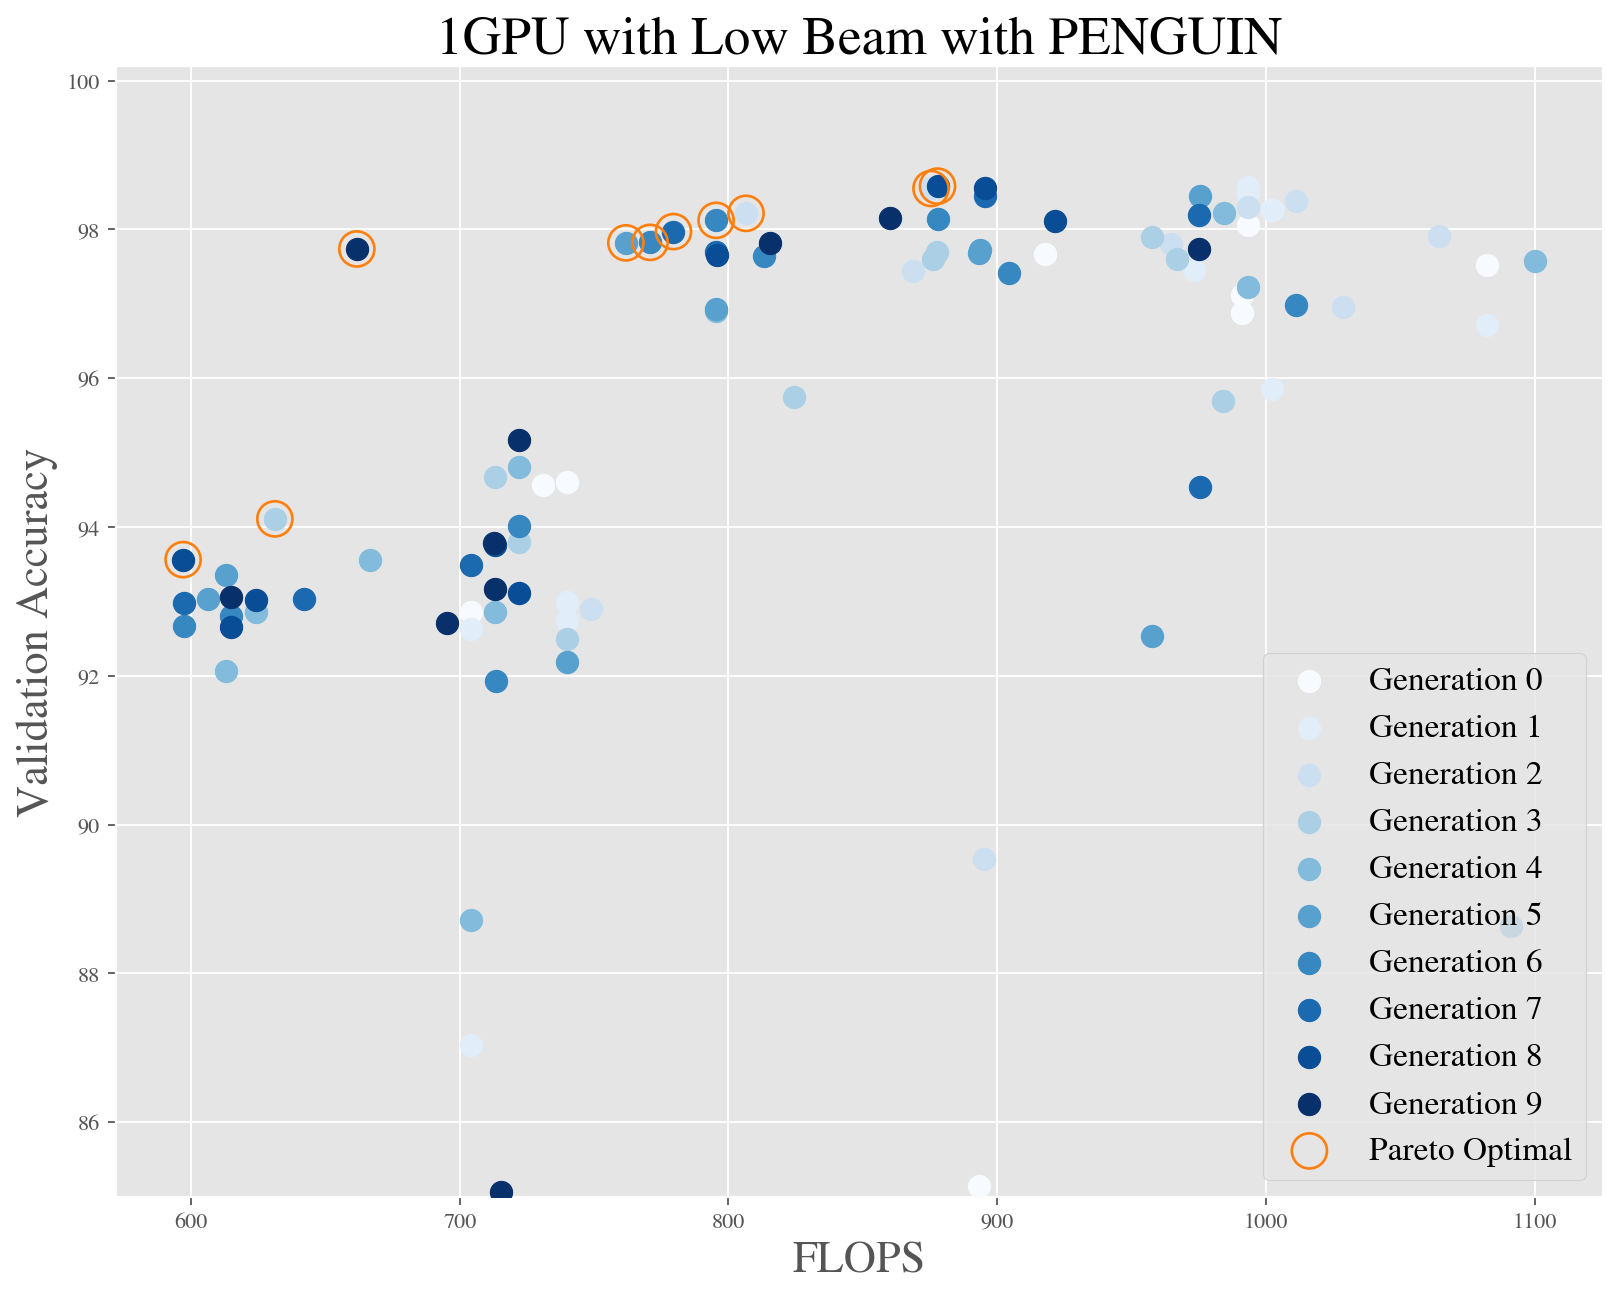


Paretos For Low Beam:
     arch  final_acc     flops  converged  pareto_optimal
20    20  98.544974  984.4971      False            True
51    51  98.463089  975.6405      False            True
59    59  96.649030  517.2993       True            True
72    72  98.318216  713.2612      False            True
78    78  91.591081  352.5300      False            True
82    82  98.368607  877.5112      False            True
83    83  98.274124  695.2612       True            True
89    89  93.065004  450.5059      False            True
92    92  97.026959  535.2993      False            True
93    93  97.959184  632.9984      False            True
96    96  91.679264  434.6550       True            True


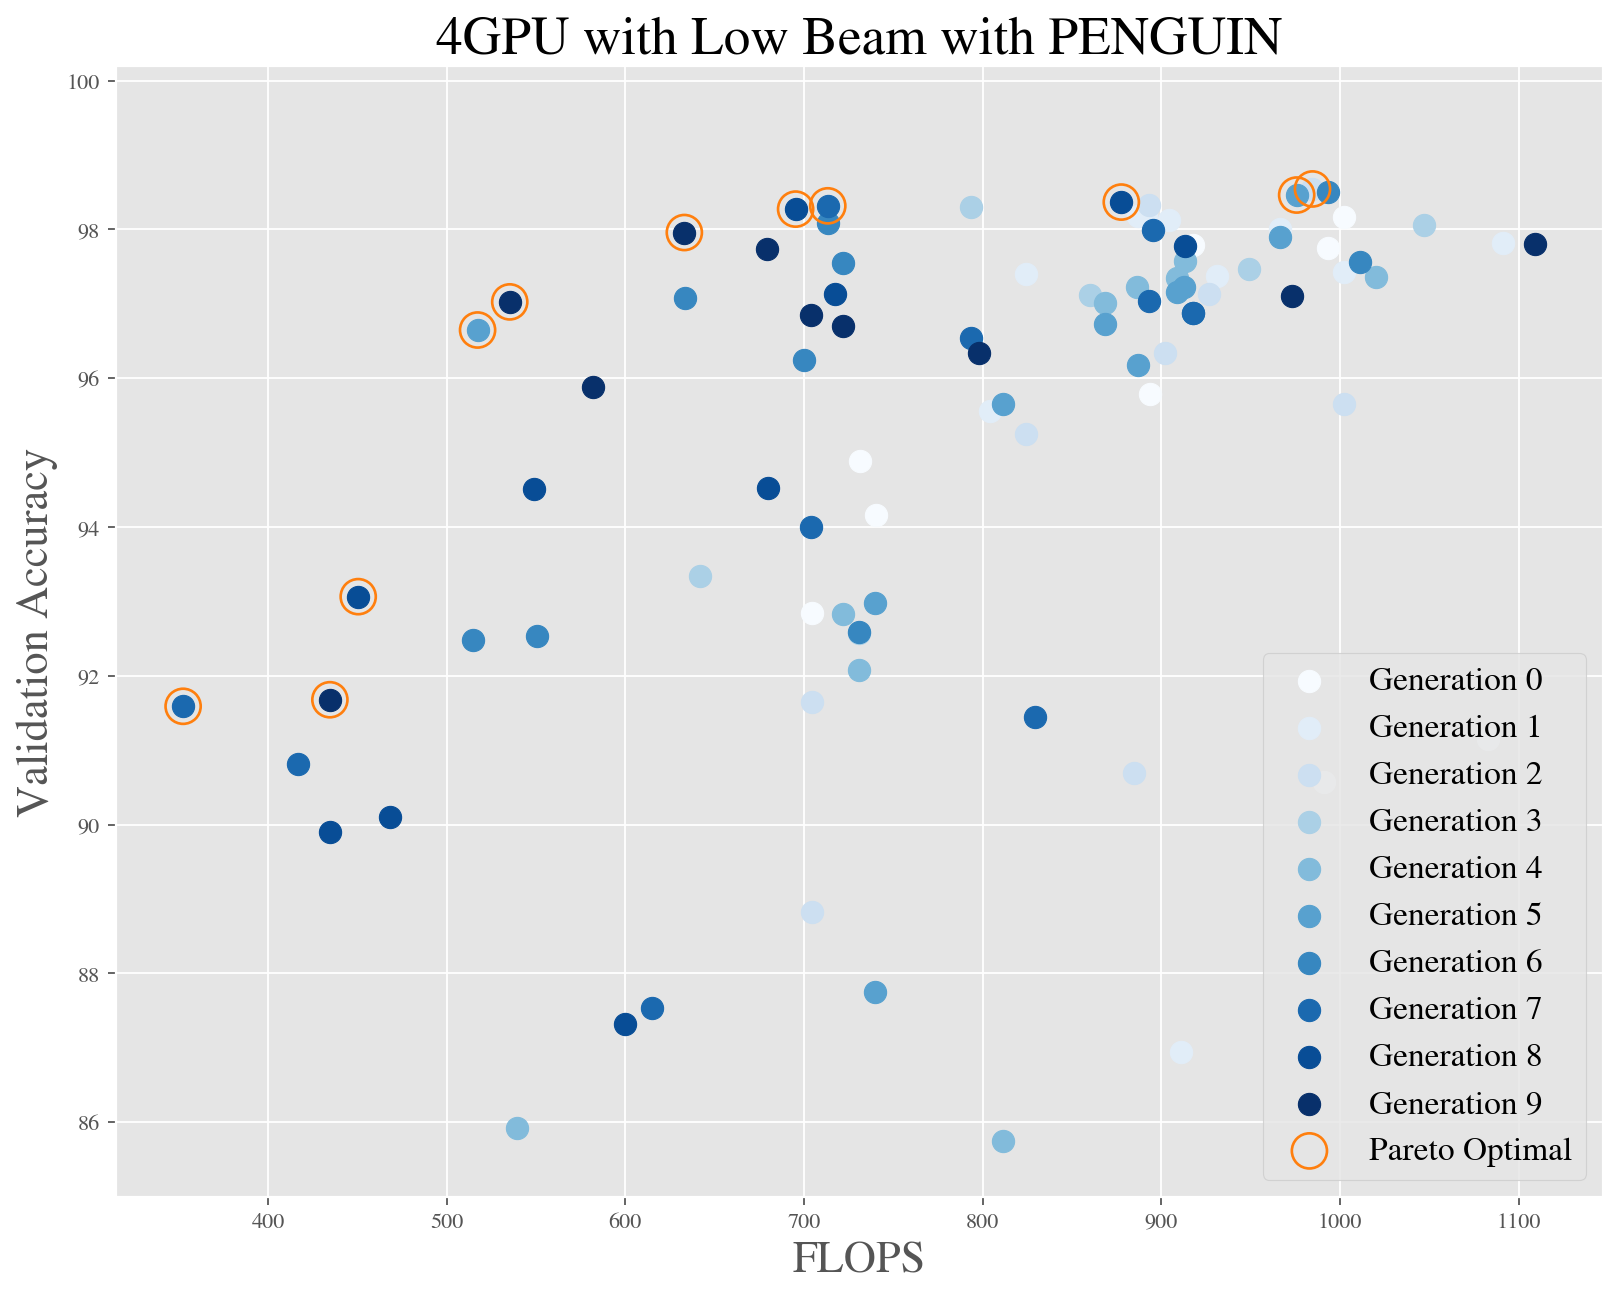


Paretos For Medium Beam:
     arch  final_acc      flops  converged  pareto_optimal
10    10  99.962207  1108.8993      False            True
12    12  99.559083   599.7112      False            True
30    30  99.987402  1117.8993      False            True
31    31  99.949609   973.3480      False            True
41    41  99.628370   615.5621      False            True
48    48  95.679012   352.8169       True            True
50    50  89.783321   187.1250      False            True
53    53  99.937012   679.6971      False            True
67    67  96.730915   434.9419       True            True
69    69  99.533888   517.5862      False            True
76    76  92.183170   269.2500      False            True
81    81  82.344419   169.1250       True            True
89    89  94.381456   334.8169       True            True
93    93  91.994205   251.2500      False            True
99    99  59.063996     0.0161       True            True


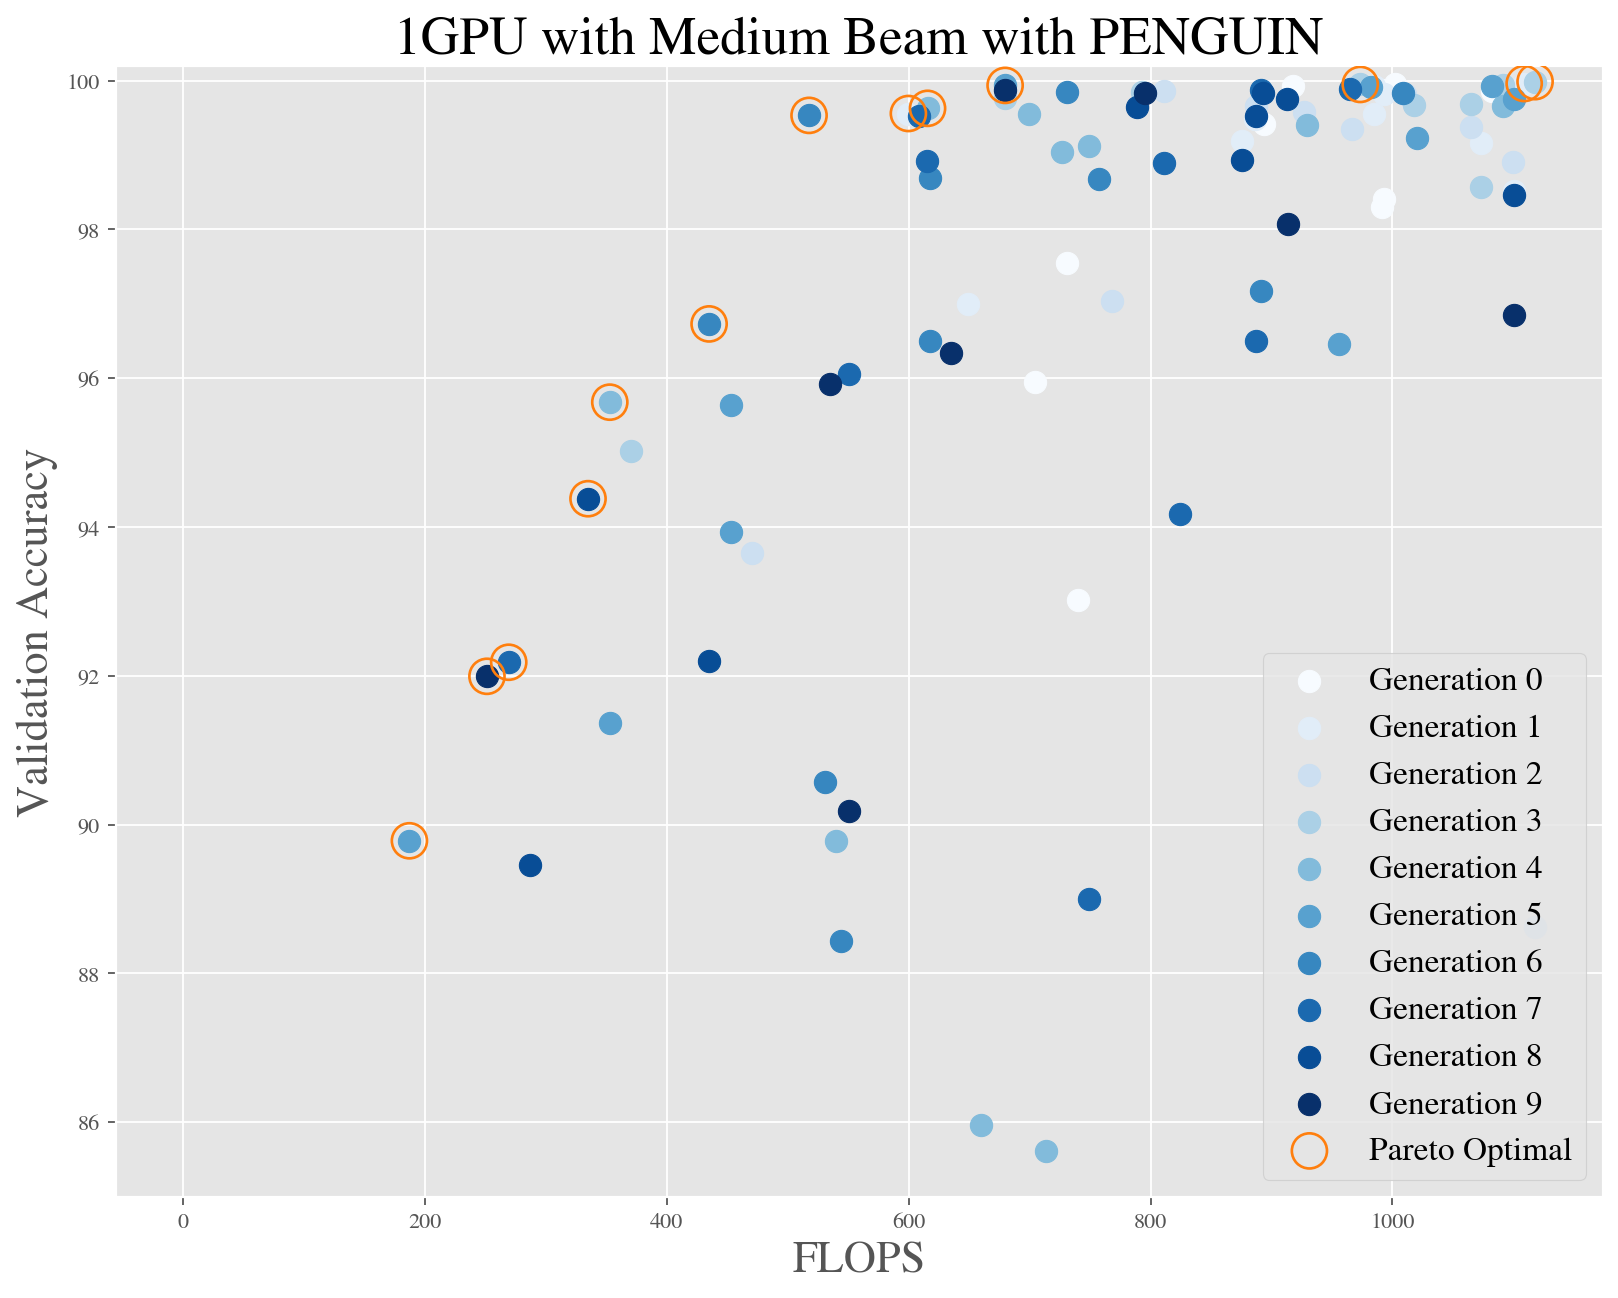


Paretos For Medium Beam:
     arch  final_acc     flops  converged  pareto_optimal
37    37  97.902494  595.4673       True            True
40    40  99.275636  697.4103       True            True
41    41  99.918115  875.6590      False            True
50    50  99.930713  875.9357      False            True
61    61  95.332577  515.2046       True            True
64    64  99.911817  704.4046      False            True
72    72  98.507181  613.4673       True            True
73    73  94.683799  434.9419       True            True
77    77  99.974805  973.6348      False            True
81    81  99.905518  697.6971      False            True
85    85  96.705719  532.9177       True            True
92    92  99.118166  617.7112       True            True


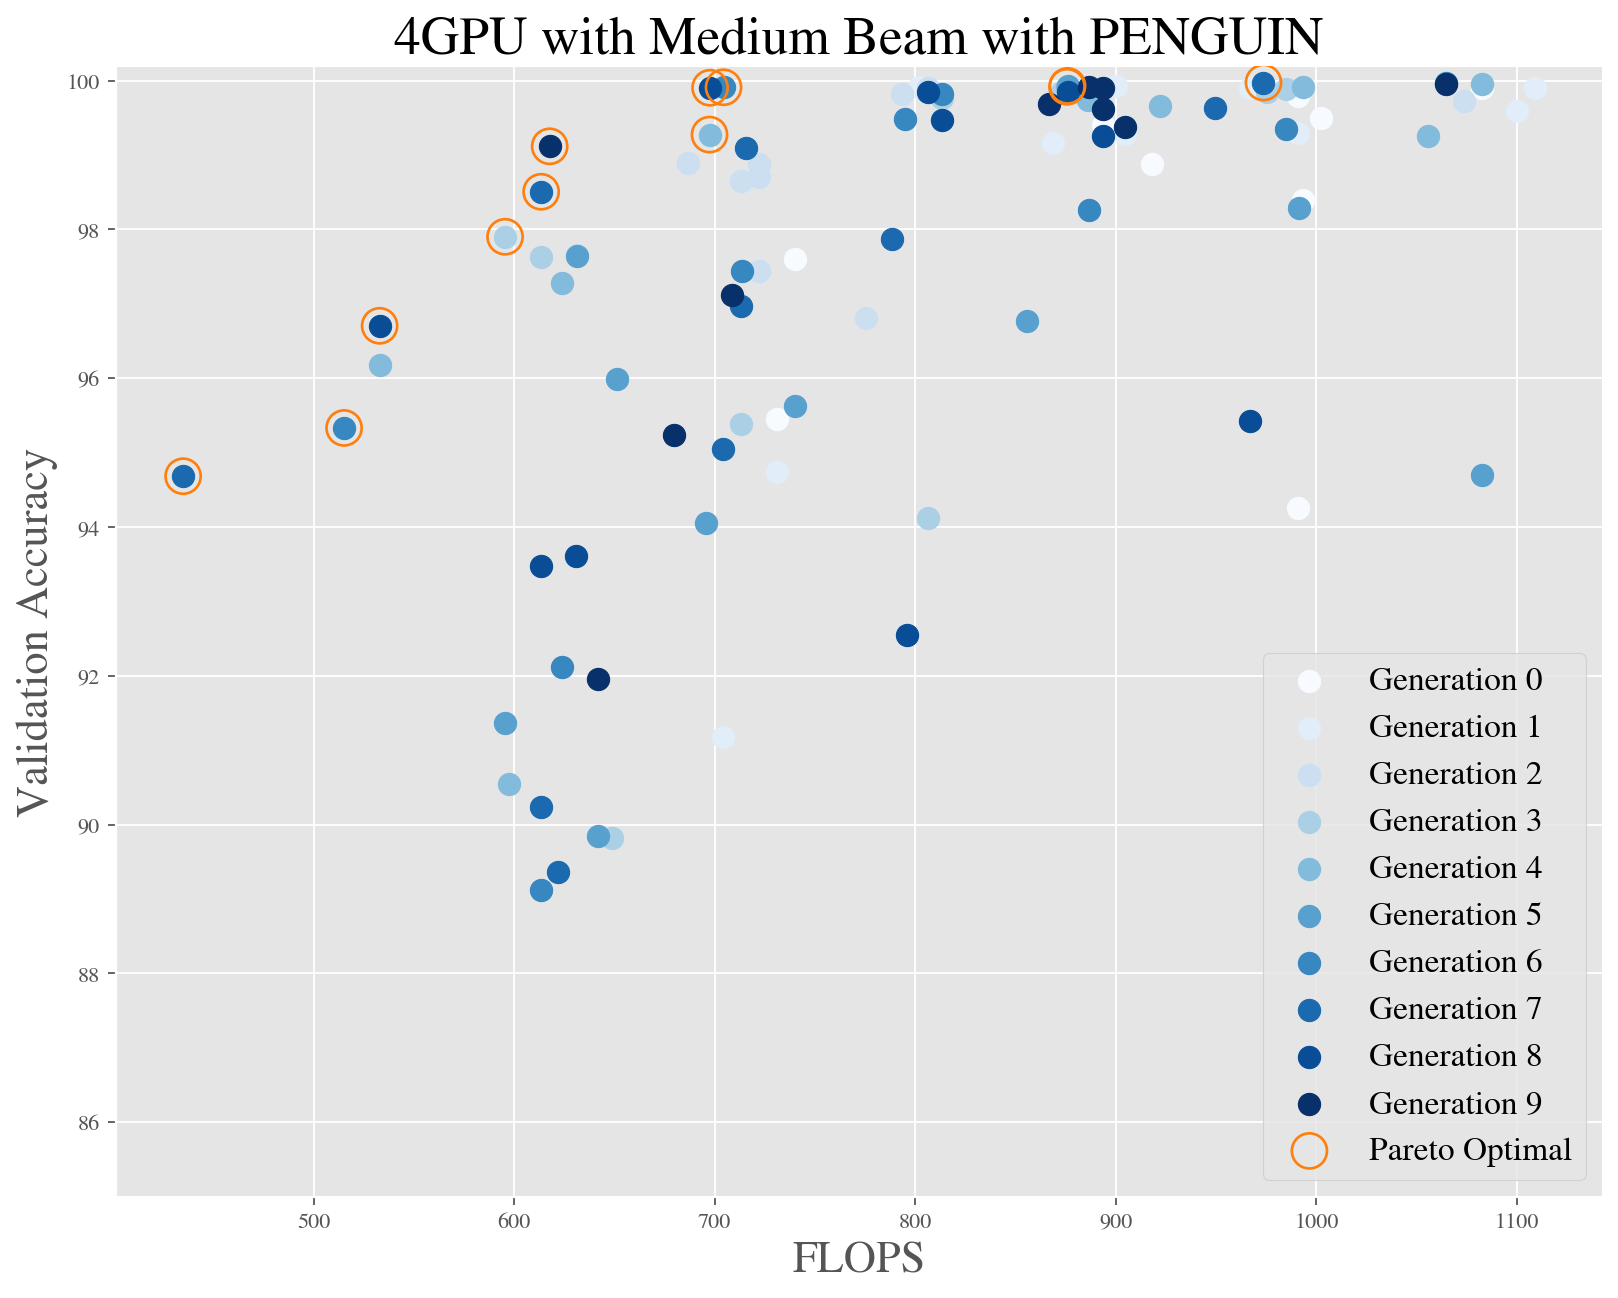


Paretos For High Beam:
     arch   final_acc     flops  converged  pareto_optimal
78    78   99.930713  470.6550      False            True
86    86  100.000000  530.7686       True            True


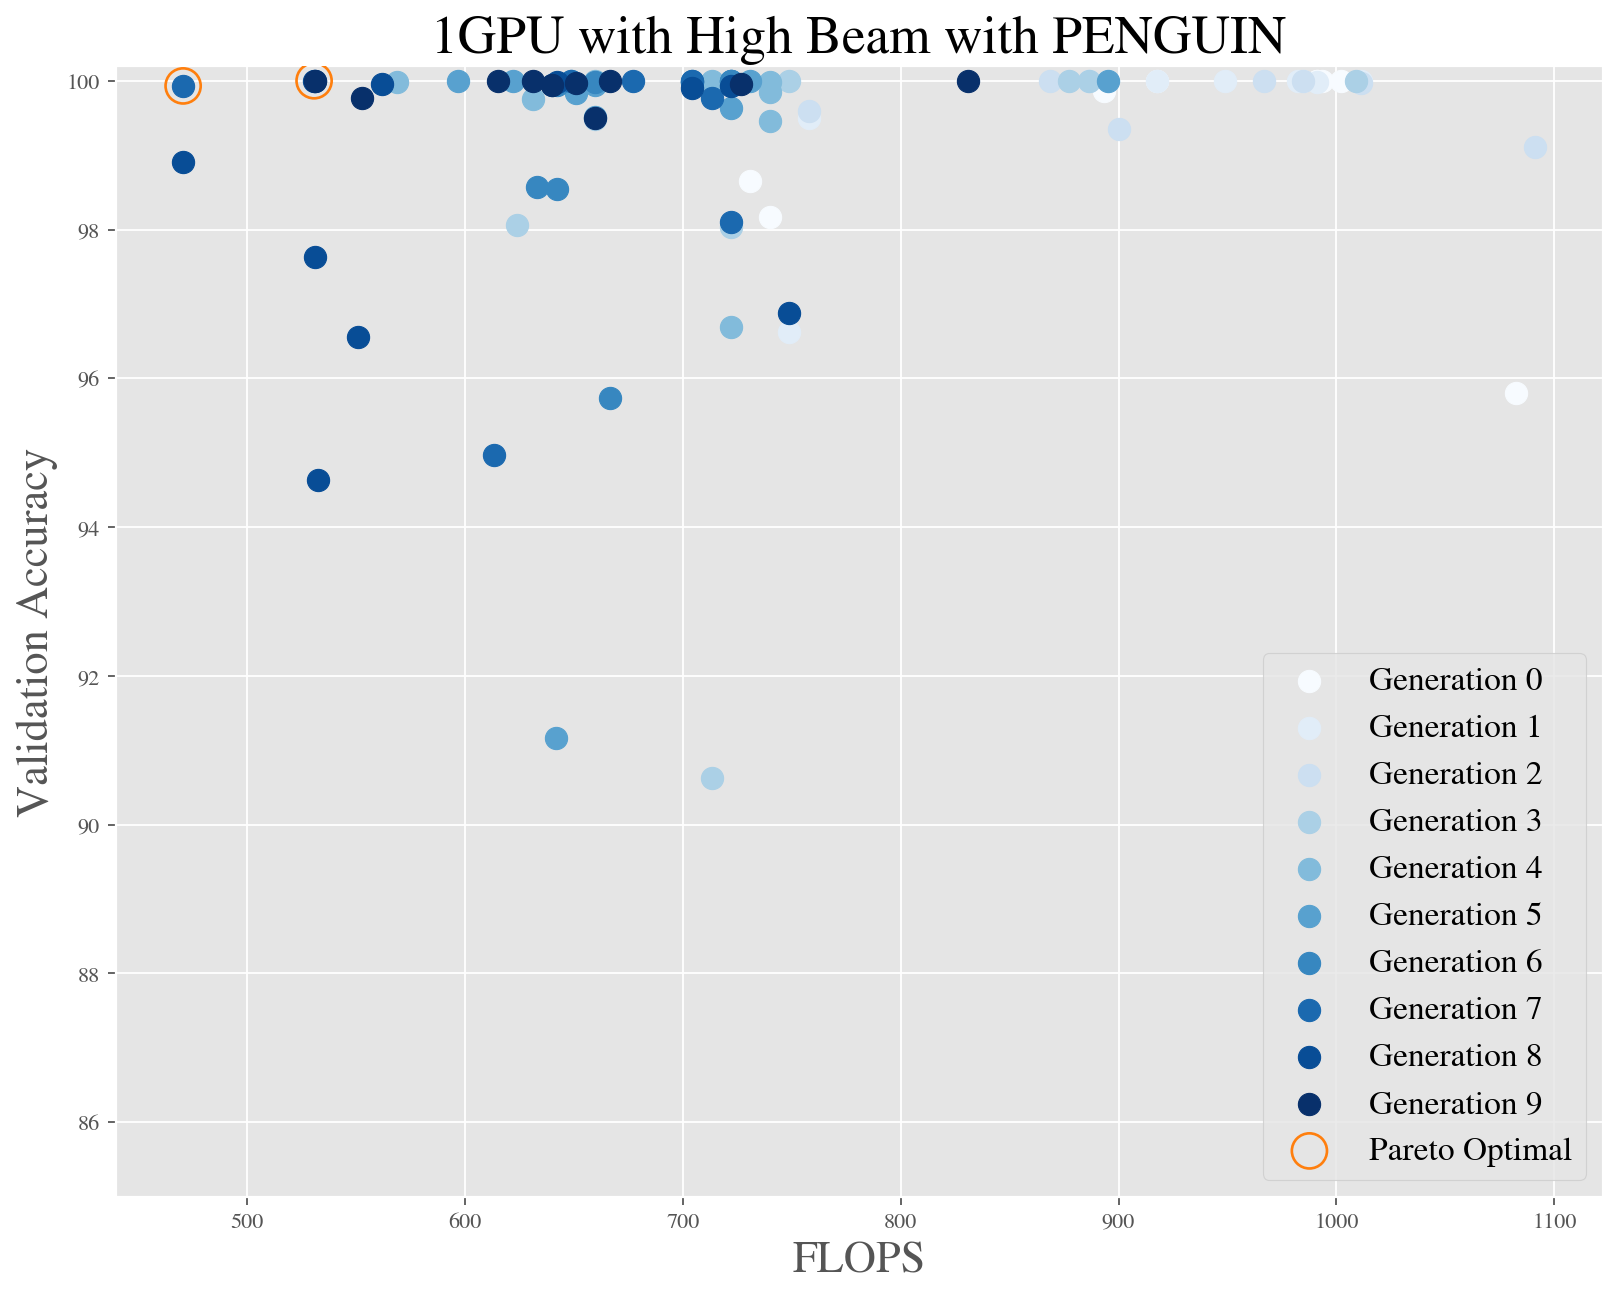


Paretos For High Beam:
     arch   final_acc     flops  converged  pareto_optimal
58    58   99.993701  595.4673      False            True
62    62  100.000000  599.7112      False            True
72    72   95.679012  269.2500      False            True
83    83   95.905770  360.3750       True            True
84    84   99.735450  434.9419      False            True


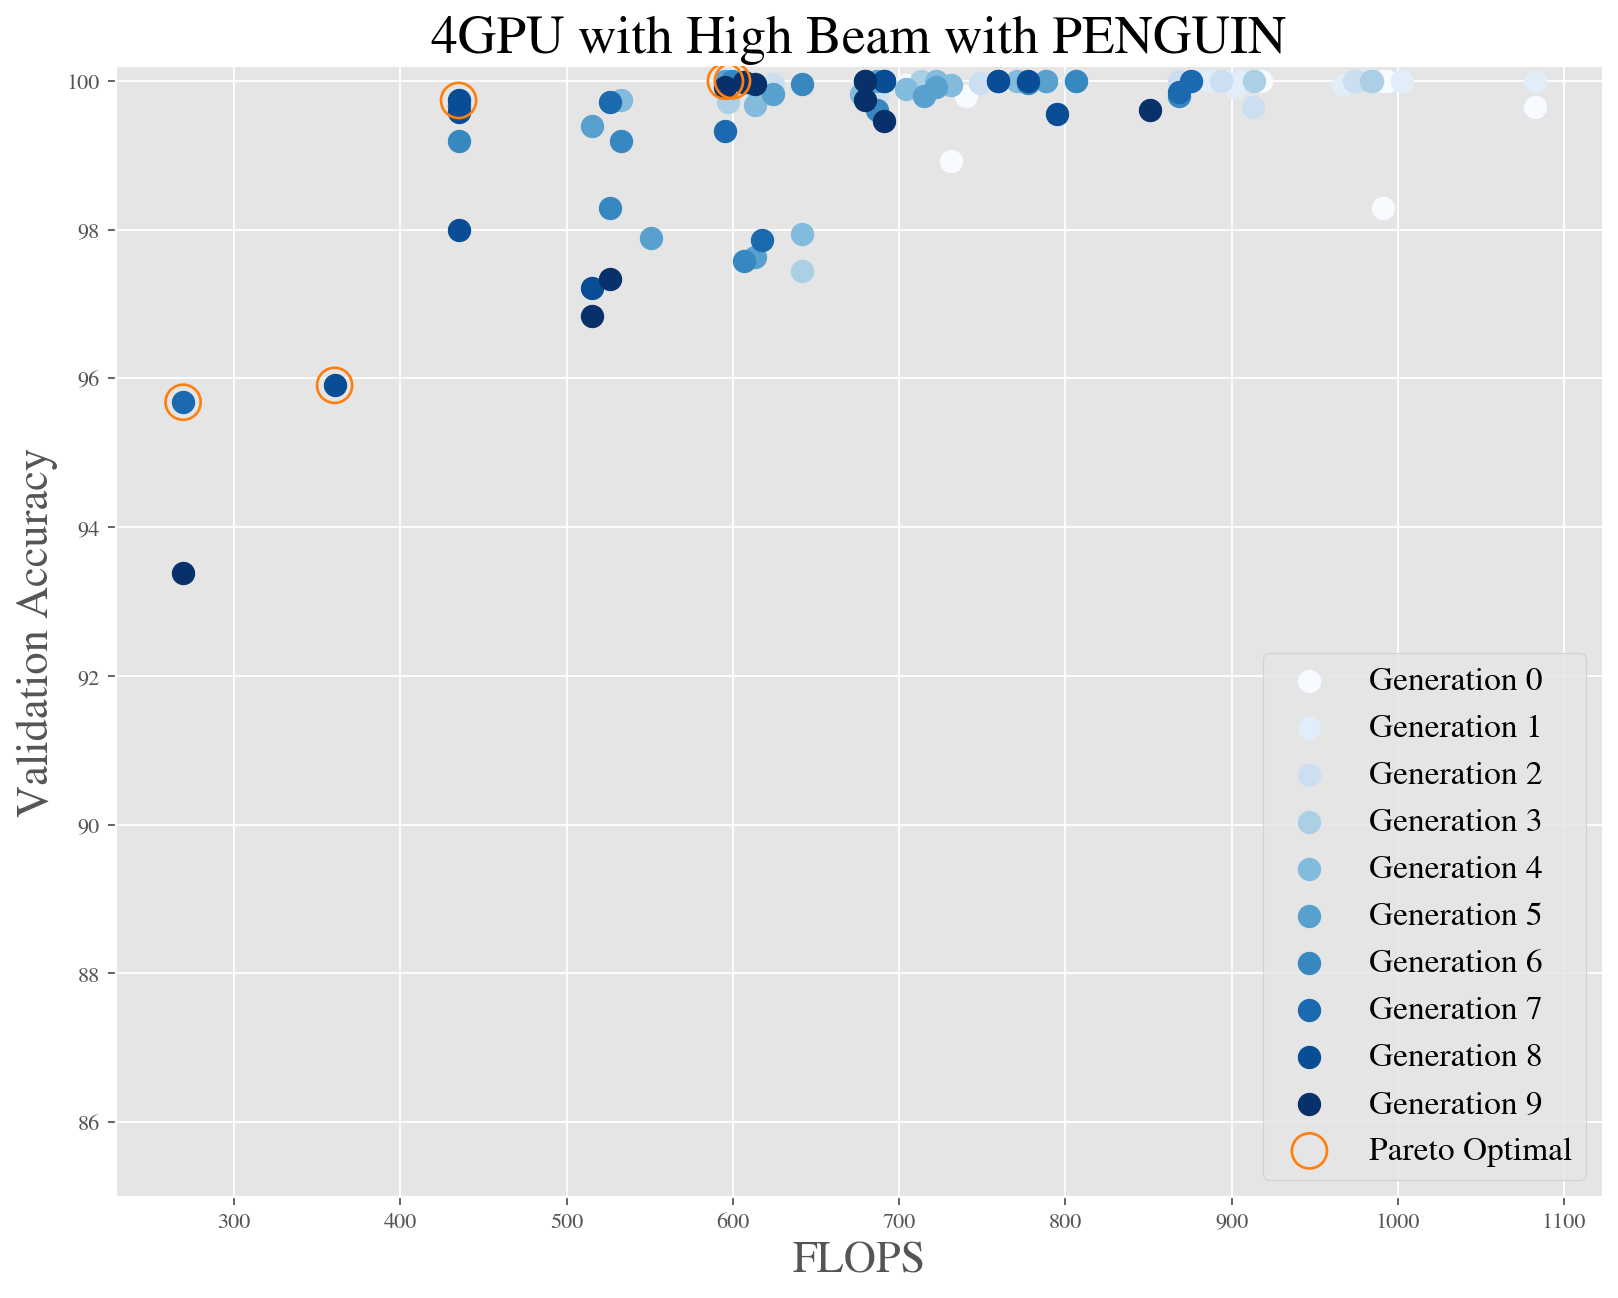

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

In [10]:
plot_paretos(no_stop, stop)